# Analysis of Specific Assays #
    - Matt Robinson, matthew67robinson@gmail.com

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

# ChEMBL 1243971 #

![small_assay](img/small_assay.png)

In [3]:
def classical_AUC_CI(AUC, n_actives, n_inactives):
    '''
    Function to compute confidence intervals for AUC values
    Uses the form provided in Nicholls (2014)
    Note that returned intervals are often asymmetric.
    '''
    import scipy.stats
    
    var_active = ((AUC**2)*(1-AUC)/(1+AUC))/n_actives
    var_inactive = (AUC*((1-AUC)**2)/(2-AUC))/n_inactives
    
    df_eff = (
        (((var_active/n_actives)+(var_inactive/n_inactives))**2) / 
        (
            (((var_active/n_actives)**2)/(n_actives-1)) +
            (((var_inactive/n_inactives)**2)/(n_inactives-1))
        )
    )
    
    std_error = np.sqrt(var_active+var_inactive)
    
    # transform to new space where continuous
    logit_auc = np.log(AUC/(1-AUC))
    logit_std_error = std_error * (1/(AUC*(1-AUC)))
    
    t_95 = scipy.stats.t.ppf(0.975,df_eff)
    logit_lower_limit = logit_auc - t_95*logit_std_error
    logit_upper_limit = logit_auc + t_95*logit_std_error
    
    lower_limit = 1/(1+np.exp(-1*logit_lower_limit))
    upper_limit = 1/(1+np.exp(-1*logit_upper_limit))
    
    return lower_limit, upper_limit, std_error
    #return std_error

In [4]:
print('95% confidence interval for fold 1: ')
print(classical_AUC_CI(0.69, 18, 18)[0:2])

95% confidence interval for fold 1: 
(0.4915510779933924, 0.8367219860981412)


In [6]:
print('95% confidence interval for fold 3: ')
print(classical_AUC_CI(0.56, 3, 3)[0:2])

95% confidence interval for fold 3: 
(0.08332212040442567, 0.9468672891386705)


For fold 1, we cannot use this approach since the number of degrees of freedom is not well defined when there is only one sample from the positive class.

Therefore, we take a different approach and simulate all those AUC values that could be achieved by a **completely random classifer**:

In [8]:
def simulated_random_AUC_scores(observed_AUC, n_actives, n_inactives, n_iters=1000):
    
    AUC_list = []
    for i in range(n_iters):
        random_ranking = np.random.permutation(range(n_actives+n_inactives))
        actives = random_ranking[:n_actives]
        inactives = random_ranking[n_actives:]
        
        mw_sum = 0
        for active in actives:
            for inactive in inactives:
                if active > inactive:
                    mw_sum += 1
       
        AUC_list.append(mw_sum/(n_actives*n_inactives))
        
    plot_scores(AUC_list, observed_AUC,
                title='Simulated AUC scores from random classifier', bins=50)

In [12]:
def plot_scores(shuffled_scores, original_score, confidence=0.95,
                title='', bins=None):
    sorted_scores = np.array(shuffled_scores)
    sorted_scores.sort()
    
    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    lower_pct = (1-(confidence))/2
    upper_pct = 1 - lower_pct
    confidence_lower = sorted_scores[int(lower_pct * len(sorted_scores))]
    confidence_upper = sorted_scores[int(upper_pct * len(sorted_scores))]
    
    
    # I think this is right, but check geq sign
    print(f'ONE-SIDED P-VALUE: {np.mean(original_score <= sorted_scores)}')
    
    if bins:
        plt.hist(sorted_scores, alpha=0.3, density=True, bins=bins)
    else:
        plt.hist(sorted_scores, alpha=0.3, density=True)
    plt.tight_layout()
    plt.axvline(x=original_score,c='red',zorder=10,label='observed score')
    plt.axvline(x=confidence_lower,c='k',linestyle='dashed',zorder=10,
                label='CI limits')
    plt.axvline(x=confidence_upper,c='k',linestyle='dashed',zorder=10)
    plt.xlabel('score')
    plt.ylabel('density')
    plt.title(title)
    plt.axvline(x=original_score)
    plt.legend()

ONE-SIDED P-VALUE: 1.0


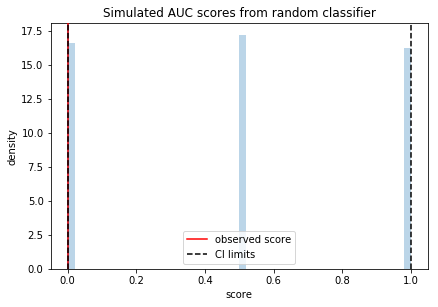

In [14]:
simulated_random_AUC_scores(0.0, 1, 2, n_iters=1000)

As one can see, there are only three possible values for the AUC in this case, so the result is essentially meaningless.

# ChEMBL 1964055 and ChEMBL 1794580 #

![two_assays](img/two_assays.png)

For fold 2, of assay A, let's use our random AUC-ROC value approach to see if the results are significant:

ONE-SIDED P-VALUE: 0.4017


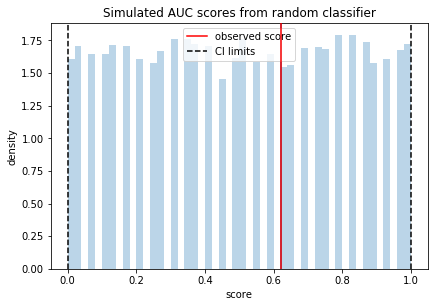

In [25]:
simulated_random_AUC_scores(0.62, 29, 1, n_iters=10000)

ONE-SIDED P-VALUE: 0.0347


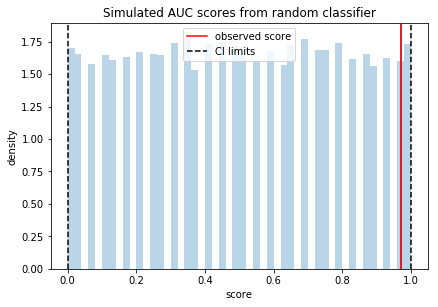

In [26]:
simulated_random_AUC_scores(0.97, 29, 1, n_iters=10000)

Even the 0.97 AUC is not significant in the event of such high class imbalance!

# Calculate effect size of SVM outperforming FNN in both assays: #

In [29]:
print('assay A effect size of SVM > FNN: ',
(
    (0.67 - 0.57)/
    np.sqrt(
        (((0.05*np.sqrt(3))**2) + ((0.14*np.sqrt(3))**2))/2
    )
))

assay A effect size of SVM > FNN:  0.5492350363810902


In [30]:
print('assay B effect size: ',
(
    (0.929 - 0.900)/
    np.sqrt(
        (((0.005*np.sqrt(3))**2) + ((0.002*np.sqrt(3))**2))/2
    )
))

assay B effect size:  4.396968652757644


Plot the assays to get a visual understanding of the results:

In [32]:
# create pandas dataframe for use with altair
A_results_df = pd.DataFrame(columns=['mean', 'lower_CI', 'upper_CI', 'model', 'fold', 'assay'])

In [33]:
A_results_df = A_results_df.append({'mean':0.44,
                'lower_CI':0.035,
                'upper_CI':0.94,
                'model':'FNN',
                'fold':'1',
                'assay':'A'}, ignore_index=True)

A_results_df = A_results_df.append({'mean':0.62,
                'lower_CI':0.1,
                'upper_CI':1,
                'model':'FNN',
                'fold':'2',
                'assay':'A'}, ignore_index=True)

A_results_df = A_results_df.append({'mean':0.64,
                'lower_CI':0.34,
                'upper_CI':0.86,
                'model':'FNN',
                'fold':'3',
                'assay':'A'}, ignore_index=True)

A_results_df = A_results_df.append({'mean':0.57,
                'lower_CI':0.34,
                'upper_CI':0.80,
                'model':'FNN',
                'fold':'All',
                'assay':'A'}, ignore_index=True)

In [34]:
A_results_df = A_results_df.append({'mean':0.38,
                'lower_CI':0.022,
                'upper_CI':0.94,
                'model':'SVM',
                'fold':'1',
                'assay':'A'}, ignore_index=True)

A_results_df = A_results_df.append({'mean':0.97,
                'lower_CI':0.89,
                'upper_CI':1,
                'model':'SVM',
                'fold':'2',
                'assay':'A'}, ignore_index=True)

A_results_df = A_results_df.append({'mean':0.68,
                'lower_CI':0.38,
                'upper_CI':0.88,
                'model':'SVM',
                'fold':'3',
                'assay':'A'}, ignore_index=True)

A_results_df = A_results_df.append({'mean':0.67,
                'lower_CI':1,
                'upper_CI':0.074,
                'model':'SVM',
                'fold':'All',
                'assay':'A'}, ignore_index=True)

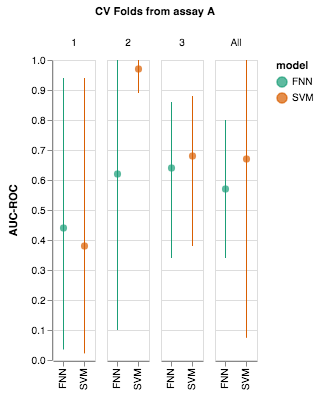

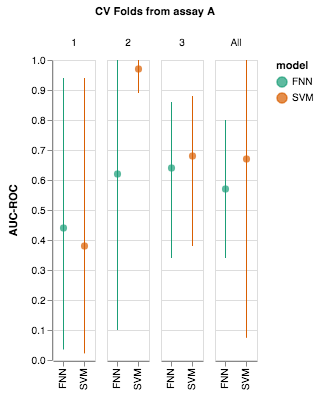

In [35]:
source = A_results_df

points = alt.Chart().mark_point(filled=True, size=50).encode(
    x= alt.X('model:O',axis=alt.Axis(title='') ),
    y= alt.Y('mean:Q', axis=alt.Axis(title='AUC-ROC', grid=True)),
    color = alt.Color('model:O', scale=alt.Scale(scheme='dark2'))
)

CI_bars = points.mark_rule().encode(
    x="model:O",
    y="lower_CI:Q",
    y2="upper_CI:Q",
)

alt.layer(points, CI_bars, data=source).facet(
    column= alt.Column('fold:N', title='CV Folds from assay A')
)

In [36]:
# create pandas dataframe for use with altair
B_results_df = pd.DataFrame(columns=['mean', 'lower_CI', 'upper_CI', 'model', 'fold', 'assay'])

In [38]:
B_results_df = B_results_df.append({'mean':0.889,
                'lower_CI':0.883,
                'upper_CI':0.895,
                'model':'FNN',
                'fold':'1',
                'assay':'B'}, ignore_index=True)

B_results_df = B_results_df.append({'mean':0.905,
                'lower_CI':0.900,
                'upper_CI':0.910,
                'model':'FNN',
                'fold':'2',
                'assay':'B'}, ignore_index=True)

B_results_df = B_results_df.append({'mean':0.906,
                'lower_CI':0.900,
                'upper_CI':0.911,
                'model':'FNN',
                'fold':'3',
                'assay':'B'}, ignore_index=True)

B_results_df = B_results_df.append({'mean':0.900,
                'lower_CI':0.880,
                'upper_CI':0.919,
                'model':'FNN',
                'fold':'All',
                'assay':'B'}, ignore_index=True)

In [39]:
B_results_df = B_results_df.append({'mean':0.926,
                'lower_CI':0.921,
                'upper_CI':0.931,
                'model':'SVM',
                'fold':'1',
                'assay':'B'}, ignore_index=True)

B_results_df = B_results_df.append({'mean':0.926,
                'lower_CI':0.921,
                'upper_CI':0.930,
                'model':'SVM',
                'fold':'2',
                'assay':'B'}, ignore_index=True)

B_results_df = B_results_df.append({'mean':0.934,
                'lower_CI':0.930,
                'upper_CI':0.939,
                'model':'SVM',
                'fold':'3',
                'assay':'B'}, ignore_index=True)

B_results_df = B_results_df.append({'mean':0.929,
                'lower_CI':0.919,
                'upper_CI':0.939,
                'model':'SVM',
                'fold':'All',
                'assay':'B'}, ignore_index=True)

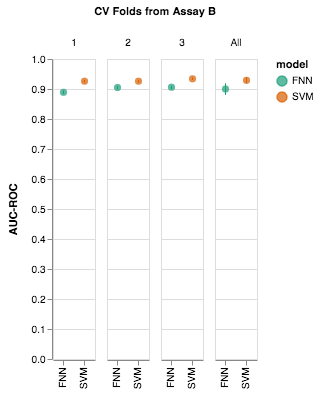

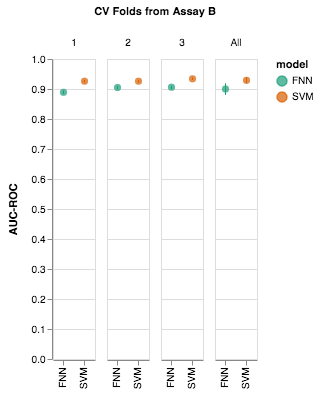

In [40]:
source = B_results_df

points = alt.Chart().mark_point(filled=True, size=50).encode(
    x= alt.X('model:O',axis=alt.Axis(title='') ),
    y= alt.Y('mean:Q', axis=alt.Axis(title='AUC-ROC', grid=True)),
    color = alt.Color('model:O', scale=alt.Scale(scheme='dark2'))
)

CI_bars = points.mark_rule().encode(
    x="model:O",
    y="lower_CI:Q",
    y2="upper_CI:Q",
)

alt.layer(points, CI_bars, data=source).facet(
    column= alt.Column('fold:N', title='CV Folds from Assay B')
)